In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
import tf_lab.point_clouds.in_out as pio

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.point_net_ae import Configuration as PN_Conf
import tf_lab.point_clouds.various_encoders_decoders as enc_dec
import tf_lab.models.point_net_based_AE as pnAE

from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.in_out import train_validate_test_split
from tf_lab.point_clouds.in_out import load_crude_point_clouds

from general_tools.in_out import create_dir
from geo_tool import Point_Cloud

In [89]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
DATA_PATH = '/Users/optas/DATA/Point_Clouds/Shape_Net_Core/from_manifold_meshes/1024/03001627'
file_names = pio.load_filenames_of_input_data(DATA_PATH)
file_names = file_names[:1000]
all_pclouds, model_names = load_crude_point_clouds(file_names=file_names, n_threads=11)


train_data, val_data, test_data = train_validate_test_split(all_pclouds, 
                                                            train_perc=0.8, 
                                                            validate_perc=0.1, 
                                                            test_perc=0.1, 
                                                            seed=seed)

train_data = PointCloudDataSet(train_data)
val_data = PointCloudDataSet(val_data)
test_data = PointCloudDataSet(test_data)

6778 files containing  point clouds were found.


In [4]:
experiment_name = 'test_ae'

conf = PN_Conf(n_input = [1024, 3],
               training_epochs = 120,
               batch_size = 40,
               loss = 'l2',
               train_dir = '/Users/optas/Desktop/panos',
               loss_display_step = 1,               
               saver_step = 5,
               saver_max_to_keep = 200,
               learning_rate=0.0002               
              )
ae = PointNetAutoEncoder(experiment_name, conf)

NameError: global name 'np' is not defined

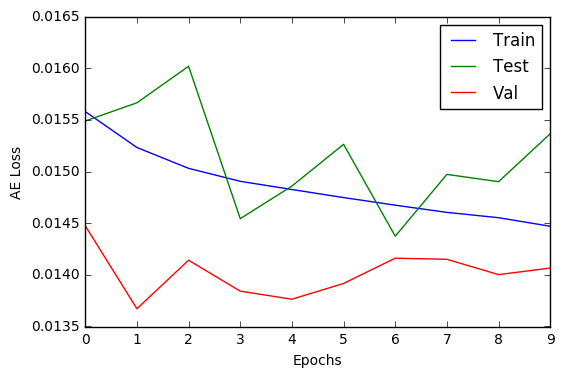

In [79]:
from autopredictors.tf_experiments.evaluate.basics import generalization_error
from autopredictors.tf_experiments.plotting.basics import plot_train_val_test_curves, plot_reconstructions_at_epoch

gen_error, best_epoch, stats = generalization_error(ae, train_data, test_data, val_data, conf)

In [91]:
# plot_train_val_test_curves(stats, '/Users/optas/Desktop/lala')
plot_reconstructions_at_epoch(int(best_epoch), ae, train_data, conf, save_dir='/Users/optas/Desktop/lala/train_images', max_plot=10)

[[  5.00000000e+00   1.55799482e-02   1.54890763e-02   1.44743221e-02]
 [  1.00000000e+01   1.52324359e-02   1.56645970e-02   1.36721949e-02]
 [  1.50000000e+01   1.50304671e-02   1.60184735e-02   1.41413426e-02]
 [  2.00000000e+01   1.49051322e-02   1.45432260e-02   1.38421105e-02]
 [  2.50000000e+01   1.48256375e-02   1.48590454e-02   1.37641132e-02]
 [  3.00000000e+01   1.47477820e-02   1.52628538e-02   1.39163868e-02]
 [  3.50000000e+01   1.46740133e-02   1.43737993e-02   1.41610275e-02]
 [  4.00000000e+01   1.46044442e-02   1.49720297e-02   1.41504230e-02]
 [  4.50000000e+01   1.45528330e-02   1.49015822e-02   1.40020219e-02]
 [  5.00000000e+01   1.44700947e-02   1.53657007e-02   1.40657630e-02]] -0.000432161148638 10.0


In [8]:
ae.restore_model(conf.train_dir, 50)
r, l, o = ae.evaluate(train_data, conf)
print l


# a = [v for v in tf.global_variables() if v.name=='our_ap/epoch:0']
# a[0].eval(ae.sess)

0.0144700943958


In [27]:
import glob
files = glob.glob(osp.join(conf.train_dir, 'models.ckpt-*.index'))
epochs_saved = []
for f in files:
    epochs_saved.append(int(osp.basename(f)[len('models.ckpt-'):-len('.index')]))
    epochs_saved.sort()

for epoch in epochs_saved:
    ae.restore_model(conf.train_dir, epoch)
    _, l, _ = ae.evaluate(test_data, conf)
    print epoch, l

    



0.0155312293209
0.0151481349021
0.0148746860214
0.0139837288298
0.0148148634471
0.0151991788298
0.0148291303776
0.0156111437827
0.0149112157524
0.0153016629629


In [ ]:
save_dir = '/Users/optas/Desktop/lala'
counter = 0
plt.ioff()
for op, rp in zip(o, r):
    for oi, ri in zip(op, rp):
        counter += 1
        fig = Point_Cloud(points=oi).plot(show=False);
        fig.savefig(osp.join(save_dir, '%d_original.png' % (counter, ) ))
        plt.close()
        
        fig = Point_Cloud(points=ri).plot(show=False);    
        fig.savefig(osp.join(save_dir, '%d_reconstructed.png' % (counter, ) ))
        plt.close()

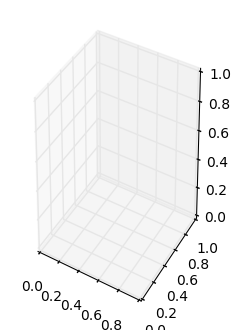